<h1>Exploring the limit order book data</h1>

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg

In [81]:
df = pd.read_csv("../../data/raw/msft.csv")
df["mid_price"] = (df["bid_price"] + df["offer_price"]) / 2
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp")

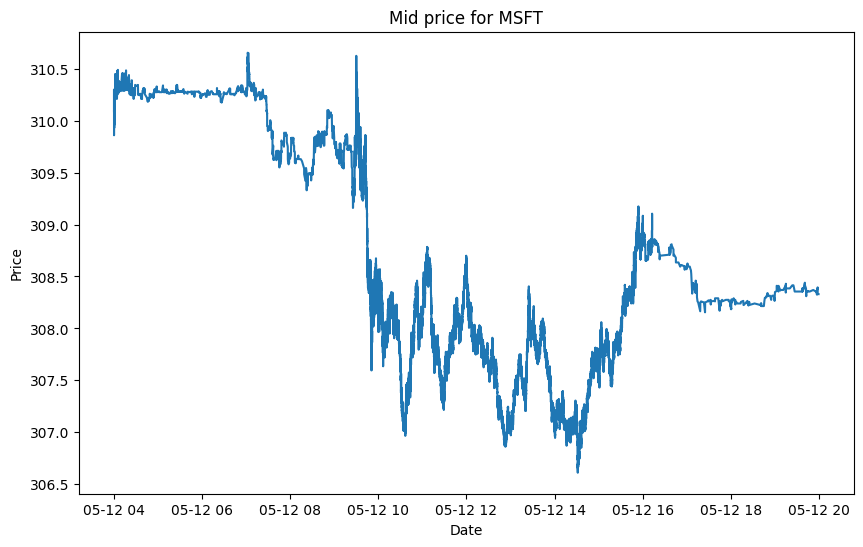

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], df["mid_price"])
plt.title("Mid price for MSFT")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

<h3>Autocorrelation</h3>

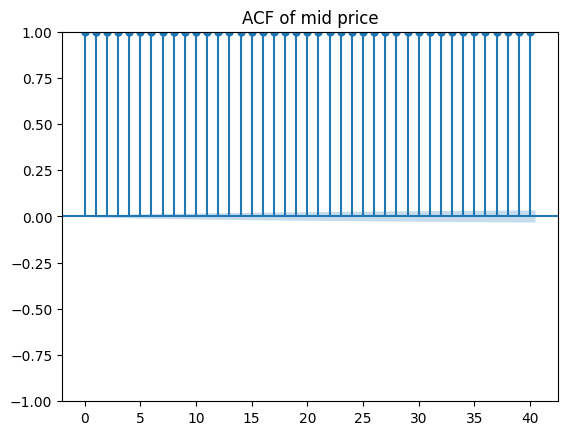

In [83]:
# should ensure regular sampling when using acf
plot_acf(df["mid_price"], lags=40) 
plt.title("ACF of mid price")
plt.show()

<h3>Analysis of timediffs</h3>

In [84]:
time_diffs = df["timestamp"] - df["timestamp"].shift()
time_diffs = pd.to_timedelta(time_diffs)
time_diffs = time_diffs.dt.total_seconds()

time_diffs_windsorized = time_diffs.copy()
quantile_90 = time_diffs.quantile(0.9)
time_diffs_windsorized.loc[time_diffs_windsorized >= quantile_90] = quantile_90

In [85]:
print(time_diffs.describe())
print(time_diffs_windsorized.describe())
print(f'Kurtosis: {time_diffs.kurtosis()}')

count    276186.000000
mean          0.208467
std           3.848367
min           0.001000
25%           0.001000
50%           0.012000
75%           0.087000
max         770.461000
Name: timestamp, dtype: float64
count    276186.000000
mean          0.060296
std           0.085470
min           0.001000
25%           0.001000
50%           0.012000
75%           0.087000
max           0.257000
Name: timestamp, dtype: float64
Kurtosis: 9636.524449162243


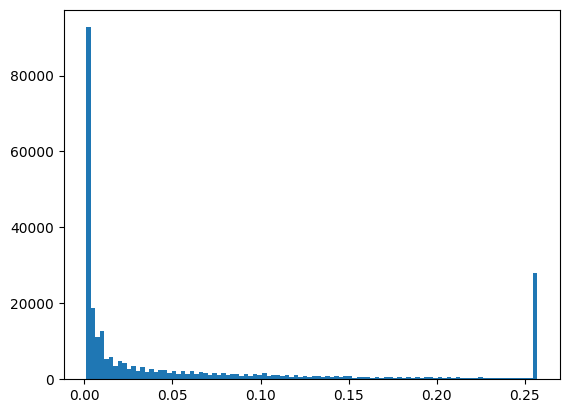

In [86]:
plt.hist(time_diffs_windsorized, bins=100)
plt.show()

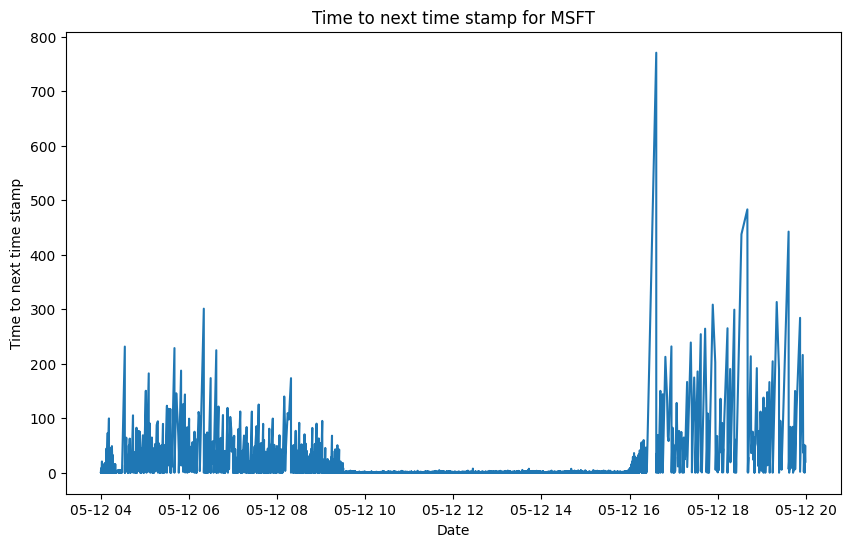

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], time_diffs)
plt.xlabel("Date")
plt.ylabel("Time to next time stamp")
plt.title("Time to next time stamp for MSFT")
plt.show()

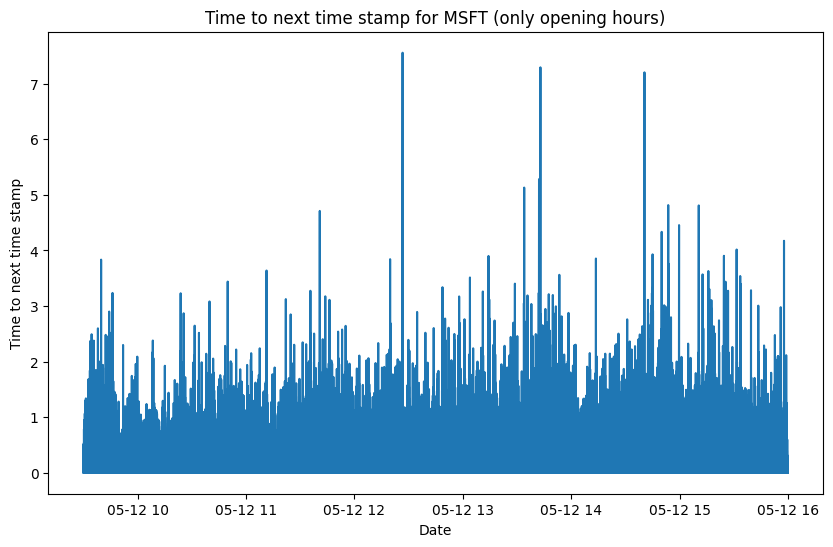

In [99]:
opening_market_idx = df.loc[(df.loc[:, "timestamp"].dt.time > pd.to_datetime("9:30").time()) & 
                            (df.loc[:, "timestamp"].dt.time < pd.to_datetime("16:00").time()), :].index

plt.figure(figsize=(10, 6))
plt.plot(df.loc[opening_market_idx, "timestamp"], time_diffs.loc[opening_market_idx])
plt.xlabel("Date")
plt.ylabel("Time to next time stamp")
plt.title("Time to next time stamp for MSFT (only opening hours)")
plt.show()

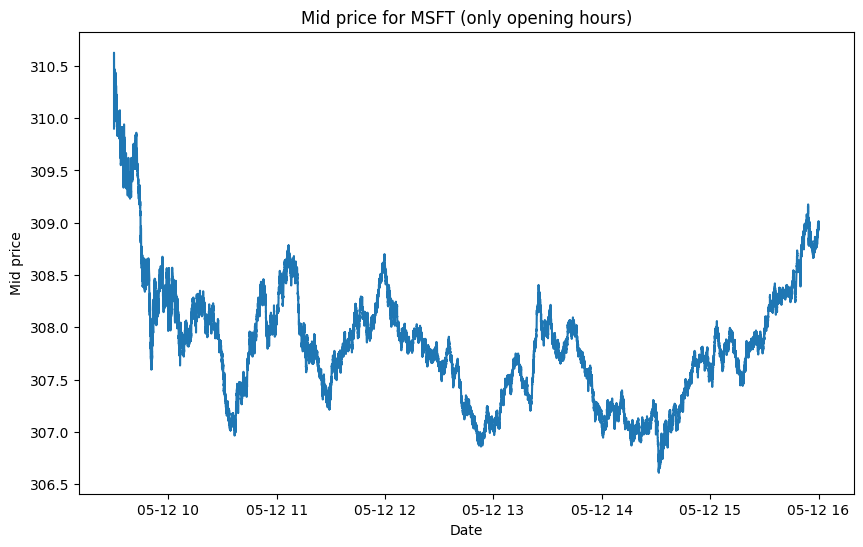

In [101]:
opening_market_idx = df.loc[(df.loc[:, "timestamp"].dt.time > pd.to_datetime("9:30").time()) & 
                            (df.loc[:, "timestamp"].dt.time < pd.to_datetime("16:00").time()), :].index

plt.figure(figsize=(10, 6))
plt.plot(df.loc[opening_market_idx, "timestamp"], df.loc[opening_market_idx, "mid_price"])
plt.xlabel("Date")
plt.ylabel("Mid price")
plt.title("Mid price for MSFT (only opening hours)")
plt.show()

                            AutoReg Model Results                             
Dep. Variable:              mid_price   No. Observations:               276187
Model:                     AutoReg(5)   Log Likelihood              990570.232
Method:               Conditional MLE   S.D. of innovations              0.007
Date:                Mon, 21 Oct 2024   AIC                       -1981126.465
Time:                        15:44:03   BIC                       -1981052.763
Sample:                             5   HQIC                      -1981105.072
                               276187                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0233      0.006      3.702      0.000       0.011       0.036
mid_price.L1     0.8864      0.002    466.799      0.000       0.883       0.890
mid_price.L2     0.1123      0.003     44.31

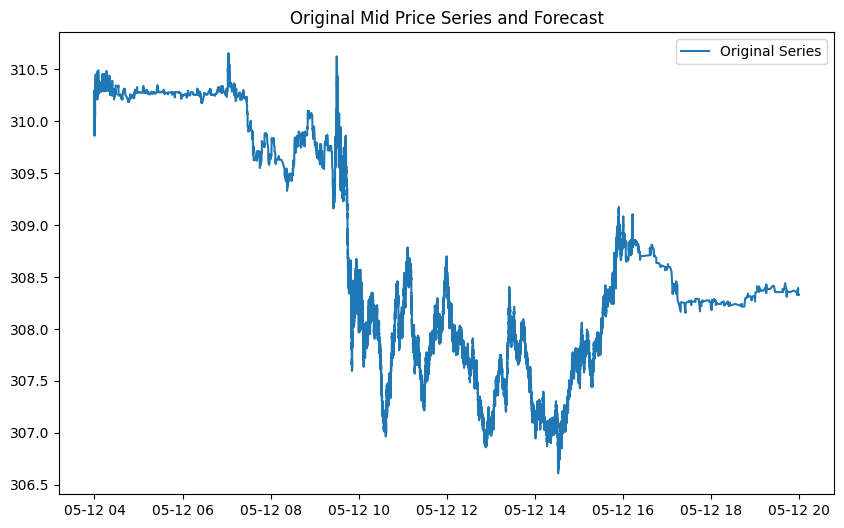

In [89]:
model = AutoReg(df["mid_price"], lags=5).fit()
print(model.summary())

forecast = model.predict(start=len(df["mid_price"]), end=len(df["mid_price"]) + 9)
print("Forecasted Values:", forecast)

# Plotting the original series and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df["timestamp"], df["mid_price"], label='Original Series')
# plt.plot(range(len(df["mid_price"]), len(df["mid_price"]) + 10), forecast, label='Forecast', color='red')
plt.legend()
plt.title("Original Mid Price Series and Forecast")
plt.show()